In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer
from sklearn.utils import class_weight
from _functions import plot_confusion_matrix, custom_classification_report

In [2]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [3]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']

# location, description, requirements, country will be dropped.
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+X_cat_cols+y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col]

In [4]:
##################################
##### Define hyperparameters #####
##################################

svm_params = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': [0.1, 1, 10]
}

In [5]:
###########################
##### Train the model #####
###########################
fbeta = make_scorer(fbeta_score, beta=2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", SVC(random_state=42))
])


# compute class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values.ravel())
class_weights = dict(enumerate(weights))

# set parameters for estimator
model.set_params(clf__class_weight=class_weights)
model.set_params(clf__class_weight=class_weights)

k = 5
kF = KFold(n_splits=k, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    estimator=model,
    param_grid=svm_params,
    scoring=fbeta,
    cv=kF,
    n_jobs=-1,
    verbose=1
)


svm_grid.fit(X_train, y_train)
best_svm_model = svm_grid.best_estimator_
# Make predictions and print classification report
y_pred = best_svm_model.predict(X_test)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

Best parameters: {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
Classification Report:
           precision    recall  f1-score  f2-score   support

Not Fraud       0.99      0.99      0.99      0.99      3361
    Fraud       0.82      0.90      0.86      0.88       246

 accuracy                                     0.98      3607

F2 Score: 0.8844621513944223


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'SVM Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

<Figure size 600x500 with 0 Axes>

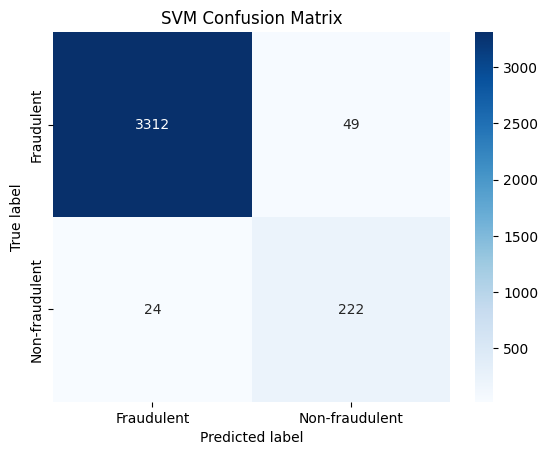

In [9]:
###########################
##### Display results #####
###########################

print("Best parameters:", svm_grid.best_params_)
print("Classification Report:")
print(custom_classification_report(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2, average='binary'))
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"SVM Confusion Matrix")

In [12]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = f'models/svm_model_k={k}.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_svm_model, file)